**The goal of this notebook to develop a machine learning model to identify whether an url is authentic or not**

Authentic and fake websites, though share innumerable similarities when seen through the naked eye, have several conflicting differences. These differences can only be identified through programming. Python libraries provide snippets for detection of these details without hassle.

In [2]:
#Import all the necessary libraries in one cell
import pandas as pd
import numpy as np
from selenium import webdriver
import requests
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from urllib.parse import urlparse
import ipaddress
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import whois
import tensorflow as tf
from tensorflow.keras import regularizers
import urllib
import requests
import urllib.request
import warnings

warnings.filterwarnings('ignore')
from datetime import datetime

Matplotlib is building the font cache; this may take a moment.


In [ ]:
#Extracts the domain name of the url
def getDomain(url):
    domain = urlparse(url).netloc
    if re.match(r"^www.",domain):
        domain = domain.replace("www.","")
    return domain

#Checks whether the url has an IP address
def havingIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip

#Checks whether the url has '@' sign in it
def haveAtSign(url):
    if "@" in url:
        at = 1
    else:
        at = 0
    return at

#Retrieves the url length
def getLength(url):
    if len(url) < 54:
        length = 0
    else:
        length = 1
    return length

#Gets the url depth, i.e., how many html pages into the url is the link
def getDepth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth

#Checks whether the url leads to other websites
def redirection(url):
    pos = url.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

#Whether the domain is tricked to display http/https
def httpDomain(url):
    domain = urlparse(url).netloc
    if 'https' in domain:
        return 1
    else:
        return 0

shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"


#Checking for Shortening Services in URL (Tiny_URL)
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

#Check for '-' in the url
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1
    else:
        return 0

In [ ]:
# 12.Web traffic (Web_Traffic)
def web_traffic(url):
    try:
        # Filling the whitespaces in the URL if any
        url = urllib.parse.quote(url)
        rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find("REACH")['RANK']
        rank = int(rank)
    except (TypeError, KeyError, ValueError, urllib.error.URLError):
        return 1  # Returning 1 for any error
    if rank < 100000:
        return 1
    else:
        return 0

#The minimum age for a legitimate domain is set as 12 months
def domainAge(domain_name):
  creation_date = domain_name.creation_date
  expiration_date = domain_name.expiration_date
  if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
    try:
      creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if ((expiration_date is None) or (creation_date is None)):
      return 1
  elif ((type(expiration_date) is list) or (type(creation_date) is list)):
      return 1
  else:
    ageofdomain = abs((expiration_date - creation_date).days)
    if ((ageofdomain/30) < 6):
      age = 1
    else:
      age = 0
  return age

def domainEnd(domain_name):
  expiration_date = domain_name.expiration_date
  if isinstance(expiration_date,str):
    try:
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if (expiration_date is None):
      return 1
  elif (type(expiration_date) is list):
      return 1
  else:
    today = datetime.now()
    end = abs((expiration_date - today).days)
    if ((end/30) < 6):
      end = 0
    else:
      end = 1
  return end

#Checks for the presence of inline documents
def iframe(response):
  if response == "":
      return 1
  else:
      if re.findall(r"[|]", response.text):
          return 0
      else:
          return 1

#On mouseover, change should be observed in authentic websites
def mouseOver(response):
  if response == "" :
    return 1
  else:
    if re.findall("", response.text):
      return 1
    else:
      return 0

#right click is disabled in fake websites to avoid inspection
def rightClick(response):
  if response == "":
    return 1
  else:
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1

#Count how many times the url has been forwarded. If none, then fake
def forwarding(response):
  if response == "":
    return 1
  else:
    if len(response.history) <= 2:
      return 0
    else:
      return 1

In [ ]:
def featureExtraction(url,label):

  features = []
  #Address bar based features (10)
  features.append(getDomain(url))
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(tinyURL(url))
  features.append(prefixSuffix(url))

  #Domain based features (4)
  dns = 0
  try:
    domain_name = whois.whois(urlparse(url).netloc)
  except:
    dns = 1

  features.append(dns)
  features.append(web_traffic(url))
  features.append(1 if dns == 1 else domainAge(domain_name))
  features.append(1 if dns == 1 else domainEnd(domain_name))

  # HTML & Javascript based features (4)
  try:
    response = requests.get(url)
  except:
    response = ""
  features.append(iframe(response))
  features.append(mouseOver(response))
  features.append(rightClick(response))
  features.append(forwarding(response))
  features.append(label)

  return features

In [ ]:
phish_features = []
label = 1
for i in range(0, 250):
  url = phishurl['url'][i]
  phish_features.append(featureExtraction(url,label))

#Add all the features into the phishing dataset
#converting the list to dataframe
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection',
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic',
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards', 'Label']

phishing = pd.DataFrame(phish_features, columns= feature_names)
phishing.head()

In [ ]:
phish_features = []
label = 1
for i in range(250, 500):
  url = phishurl['url'][i]
  phish_features.append(featureExtraction(url,label))

#Add all the features into the phishing dataset
#converting the list to dataframe
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection',
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic',
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards', 'Label']


phishing2 = pd.DataFrame(phish_features, columns= feature_names)
phishing = pd.concatenate([phishing, phishing2], axis = 0)

TypeError: can't subtract offset-naive and offset-aware datetimes

In [ ]:
phishing['url'] = ''
phishing['url'] = phishurl['url']

In [ ]:
phishing.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label,url
0,newburycafe.co.za,0,0,1,4,0,0,0,0,0,1,0,1,0,1,1,0,1,http://newburycafe.co.za/Webmail/41/Webmail/we...
1,aol-109024.weeblysite.com,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,https://aol-109024.weeblysite.com/
2,pixels-verify.pages.dev,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,http://pixels-verify.pages.dev
3,multicoin-system.web.app,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,https://multicoin-system.web.app/
4,att-100183.weeblysite.com,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,https://att-100183.weeblysite.com/


In [ ]:
phishing.to_csv('phishing.csv', index=False)

In [ ]:
#Select 20 samples from the dataset of legitimate urls

leg = pd.read_csv('/content/1.Benign_list_big_final.csv')
leg.columns = ['URLs']

legiurl = leg.sample(n = 1000, random_state = 12).copy()
legiurl = legiurl.reset_index(drop=True)
legiurl.head()

legi_features = []
label = 0

for i in range(0, 250):
  url = legiurl['URLs'][i]
  legi_features.append(featureExtraction(url,label))

#Add all the features into the phishing dataset
#converting the list to dataframe
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection',
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic',
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards', 'Label']

legitimate = pd.DataFrame(legi_features, columns= feature_names)
legitimate['url'] = legiurl['URLs']

2024-04-30 09:06:12,642 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known


In [ ]:
legi_features = []
label = 0

for i in range(250, 500):
  url = legiurl['URLs'][i]
  legi_features.append(featureExtraction(url,label))
legitimate2 = pd.DataFrame(legi_features, columns= feature_names)
legitimate = pd.concatenate([legitimate, legitimate2],axis=0)
legitimate['url'] = legiurl['URLs']
legitimate.head()

In [ ]:
legitimate.to_csv('legitimate.csv', index=False)

In [ ]:
urldata = pd.concat([legitimate, phishing]).reset_index(drop=True)
urldata.head()

In [ ]:
# Storing the data in CSV file
urldata.to_csv('urldata.csv', index=False)

NameError: name 'urldata' is not defined

In [3]:
urldata = pd.read_csv('urldata.csv')

In [4]:
#Shuffle data points to improve generalizability of the model.

urldata = urldata.sample(frac=1).reset_index(drop = True)
urldata.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,gansta-paradise.com,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1
1,webmailadmin0.myfreesites.net,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
2,scanmail.trustwave.com,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1
3,snapchat.accounts.crimsonmart.com,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,1
4,momoshop.com.tw,0,0,1,2,0,0,0,0,0,1,0,1,1,1,1,1,0


In [5]:
#Drop the columns that have zero contribution

df = urldata.drop(columns = ['Domain','Domain_End','Domain_Age','Right_Click','Mouse_Over', 'DNS_Record','TinyURL','https_Domain','Redirection','Have_IP','Web_Forwards'], axis = 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Have_At        10000 non-null  int64
 1   URL_Length     10000 non-null  int64
 2   URL_Depth      10000 non-null  int64
 3   Prefix/Suffix  10000 non-null  int64
 4   Web_Traffic    10000 non-null  int64
 5   iFrame         10000 non-null  int64
 6   Label          10000 non-null  int64
dtypes: int64(7)
memory usage: 547.0 KB


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Initialize the scaler and imputer
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

# Impute missing values in int columns
int_columns = df.select_dtypes(include=['int']).columns
df[int_columns] = scaler.fit_transform(df[int_columns])

In [8]:
#Function to plot the loss and accuracy curves

def loss_and_accuracy(model, history):

  los, acc = model.evaluate(X_train, y_train)

  loss = history.history['loss']
 # val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  #val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (6,4))
  plt.plot(epochs , loss , label = 'training_loss')
 # plt.plot(epochs , label = 'validation_loss')
  plt.title(f'Loss Curve: {los}')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure(figsize = (6,4))
  plt.plot(epochs , accuracy , label = 'training_accuracy')
 # plt.plot(epochs , label = 'validation_accuracy')
  plt.title(f'Accuracy Curve: {acc}')
  plt.ylim(0.0,1.0)
  plt.xlabel('epochs')
  plt.legend()

In [9]:
#Convert dataframe into arrays for model input

X = df.iloc[:,1:-1]
y = df['Label']

from sklearn.model_selection import train_test_split
#Split data into training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)
X_train.shape, y_train.shape

((8000, 5), (8000,))

In [10]:
df['Label'].value_counts()

Label
 1.0    5000
-1.0    5000
Name: count, dtype: int64

In [11]:
df['Label'] = df['Label'].replace(-1,0)
df['Label'].value_counts()

Label
1.0    5000
0.0    5000
Name: count, dtype: int64

In [12]:
#Use decision tree classifier to identify the weightage of each of the variables and drop the unnecessary ones.

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

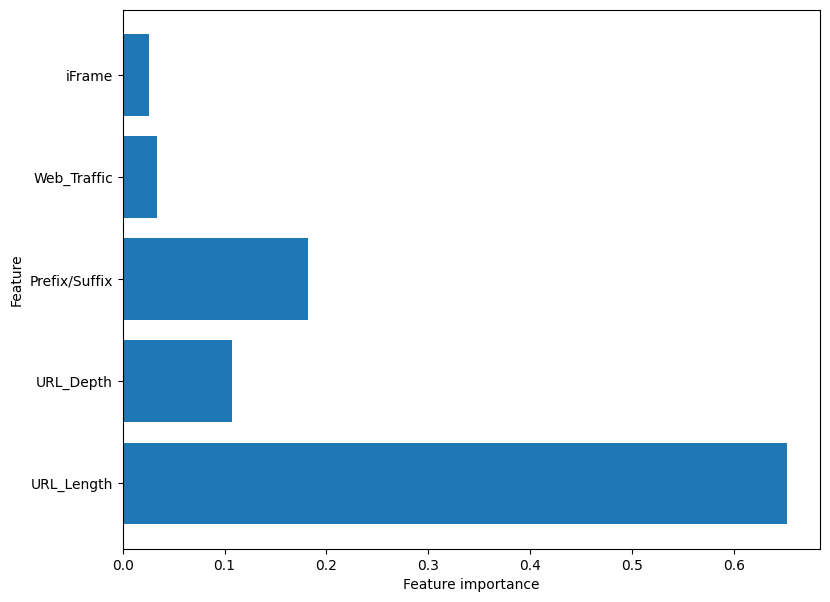

In [13]:
#checking the feature improtance in using decision trees
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=5)

#Fit the model
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [ ]:
from sklearn import svm

model = svm.SVC()

model.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_test_forest = forest.predict(X_test)
y_train_forest = forest.predict(X_train)

#computing the accuracy of the RFC model performance
acc_train_forest = accuracy_score(y_train,y_train_forest)
acc_test_forest = accuracy_score(y_test,y_test_forest)

print("Random forest: Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))
print(confusion_matrix(y_train, y_train_forest))

y_test_model = model.predict(X_test)
y_train_model = model.predict(X_train)

#computing the accuracy of the SVM model performance
acc_train_model = accuracy_score(y_train,y_train_model)
acc_test_model = accuracy_score(y_test,y_test_model)

print("Random forest: Accuracy on training Data: {:.3f}".format(acc_train_model))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_model))
print(confusion_matrix(y_train, y_train_model))

Random forest: Accuracy on training Data: 0.806
Random forest: Accuracy on test Data: 0.799
[[3948   59]
 [1489 2504]]
Random forest: Accuracy on training Data: 0.801
Random forest: Accuracy on test Data: 0.796
[[3914   93]
 [1495 2498]]


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multiclass classification
    'num_class': 2,  # Number of classes in the target variable
    'eta': 0.3,  # Learning rate
    'max_depth': 10,  # Maximum depth of the tree
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'eval_metric': 'merror'  # Evaluation metric (multiclass classification error)
}

# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
predictions = model.predict(dtest)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.8075


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Define MLP classifier
#mlp_clf = MLPClassifier(hidden_layer_sizes=([100, 100,100]), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_clf = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100]))
# Train the classifier
mlp_clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = mlp_clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.7995


In [ ]:
df['Web_Traffic'].value_counts()

Web_Traffic
1.0    8457
0.0    1543
Name: count, dtype: int64

In [ ]:
#User-defined function that can predict the URL's authenticity when the URL and method are given as arguments.

def prediction_model(url,model):
  have_at = haveAtSign(url)
  traffic = web_traffic(url)
  length = getLength(url)
  depth = getDepth(url)
  prefix = prefixSuffix(url)
  response = requests.get(url)
  ifme = iframe(response)
  output = [0,1]
  input = [have_at, length, depth, prefix, traffic, ifme]
  input = np.asarray(input)
  input = input.reshape(1,-1)
  pred = model.predict(input[0:6])
  return pred

In [ ]:
#Prediction on a sample URL
pred = prediction_model('https://www.geeksforgeeks.org/convert-python-list-to-numpy-arrays/',forest)

if pred == 0:
  print('The URL is authentic')
else:
  print("URL is malicious")

The URL is authentic


In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()

# Train the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nb_classifier.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(confusion_matrix(y_train, y_pred))

Accuracy: 0.78825
Classification Report:
[[3968   41]
 [1653 2338]]


In [ ]:
'''
ANN model with two hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric, trained on 5 epochs.
'''

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'softmax')
])

model_1.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history_1 = model_1.fit(X_train,
                    y_train,
                    epochs = 5)

Epoch 1/5
250/250 [==============================] - 9s 6ms/step - loss: 0.4948 - accuracy: 0.5030
Epoch 2/5
250/250 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.5030
Epoch 3/5
250/250 [==============================] - 1s 5ms/step - loss: 0.4080 - accuracy: 0.5030
Epoch 4/5
250/250 [==============================] - 1s 6ms/step - loss: 0.4065 - accuracy: 0.5030
Epoch 5/5
250/250 [==============================] - 2s 8ms/step - loss: 0.4043 - accuracy: 0.5030


In [ ]:
'''
ANN model with two hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric, learning rate of 0.001, trained on 20 epochs.
'''

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history_2 = model_2.fit(X_train,
                    y_train,
                    epochs = 20)

Epoch 1/20
250/250 [==============================] - 2s 3ms/step - loss: 0.4850 - accuracy: 0.7711
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4139 - accuracy: 0.8027
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4083 - accuracy: 0.8040
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4093 - accuracy: 0.8044
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4052 - accuracy: 0.8055
Epoch 6/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4035 - accuracy: 0.8039
Epoch 7/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4020 - accuracy: 0.8059
Epoch 8/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3996 - accuracy: 0.8099
Epoch 9/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4011 - accuracy: 0.8067
Epoch 10/20
250/250 [==============================] - 1s 4ms/step - loss: 0.3979 - accuracy: 0.8110

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.001, trained on 20 epochs.
'''
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history_3 = model_3.fit(X_train,
                    y_train,
                    epochs = 20)

Epoch 1/20
250/250 [==============================] - 6s 5ms/step - loss: 0.4510 - accuracy: 0.7804
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.4200 - accuracy: 0.8027
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4147 - accuracy: 0.8030
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4075 - accuracy: 0.8075
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4049 - accuracy: 0.8104
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4033 - accuracy: 0.8100
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4014 - accuracy: 0.8094
Epoch 8/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4014 - accuracy: 0.8092
Epoch 9/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3972 - accuracy: 0.8156
Epoch 10/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3948 - accuracy: 0.8154

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, trained on 15 epochs.
'''
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_4.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_4 = model_4.fit(X_train,
                    y_train,
                    epochs = 15)

Epoch 1/15
250/250 [==============================] - 3s 4ms/step - loss: 0.5118 - accuracy: 0.7701
Epoch 2/15
250/250 [==============================] - 1s 4ms/step - loss: 0.4150 - accuracy: 0.8015
Epoch 3/15
250/250 [==============================] - 1s 4ms/step - loss: 0.4075 - accuracy: 0.8036
Epoch 4/15
250/250 [==============================] - 1s 4ms/step - loss: 0.4041 - accuracy: 0.8056
Epoch 5/15
250/250 [==============================] - 1s 4ms/step - loss: 0.4028 - accuracy: 0.8094
Epoch 6/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3990 - accuracy: 0.8104
Epoch 7/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3968 - accuracy: 0.8120
Epoch 8/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3991 - accuracy: 0.8101
Epoch 9/15
250/250 [==============================] - 1s 5ms/step - loss: 0.3966 - accuracy: 0.8117
Epoch 10/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3951 - accuracy: 0.8124

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, kernel regularizer for regularization, trained on 15 epochs.
'''
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_5.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_5 = model_5.fit(X_train,
                        y_train,
                        epochs = 15)

Epoch 1/15
250/250 [==============================] - 11s 27ms/step - loss: 0.7950 - accuracy: 0.7335
Epoch 2/15
250/250 [==============================] - 7s 28ms/step - loss: 0.6393 - accuracy: 0.7879
Epoch 3/15
250/250 [==============================] - 7s 29ms/step - loss: 0.6017 - accuracy: 0.7890
Epoch 4/15
250/250 [==============================] - 7s 26ms/step - loss: 0.5763 - accuracy: 0.7914
Epoch 5/15
250/250 [==============================] - 6s 25ms/step - loss: 0.5621 - accuracy: 0.7941
Epoch 6/15
250/250 [==============================] - 6s 26ms/step - loss: 0.5489 - accuracy: 0.7954
Epoch 7/15
250/250 [==============================] - 7s 27ms/step - loss: 0.5402 - accuracy: 0.7976
Epoch 8/15
250/250 [==============================] - 7s 26ms/step - loss: 0.5347 - accuracy: 0.7961
Epoch 9/15
250/250 [==============================] - 7s 26ms/step - loss: 0.5302 - accuracy: 0.7985
Epoch 10/15
250/250 [==============================] - 6s 26ms/step - loss: 0.5253 - accur

In [ ]:
'''
ANN model with eleven hidden layers, increasing and decreasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, trained on 15 epochs.
'''
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_6.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_6 = model_6.fit(X_train,
                        y_train,
                        validation_data = (X_test, y_test),
                        epochs = 15)

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, batch normalization trained on 15 epochs.
'''
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_7.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_7 = model_7.fit(X_train,
                    y_train,
                    epochs = 15)

Epoch 1/15
250/250 [==============================] - 114s 21ms/step - loss: -247.3423 - accuracy: 0.2529
Epoch 2/15
250/250 [==============================] - 4s 15ms/step - loss: -6198.8516 - accuracy: 0.2264
Epoch 3/15
250/250 [==============================] - 4s 15ms/step - loss: -30654.6621 - accuracy: 0.1861
Epoch 4/15
250/250 [==============================] - 4s 17ms/step - loss: -86040.7344 - accuracy: 0.1700
Epoch 5/15
250/250 [==============================] - 5s 20ms/step - loss: -189522.8906 - accuracy: 0.1540
Epoch 6/15
250/250 [==============================] - 4s 16ms/step - loss: -362355.5000 - accuracy: 0.1565
Epoch 7/15
250/250 [==============================] - 4s 15ms/step - loss: -606770.6250 - accuracy: 0.1869
Epoch 8/15
250/250 [==============================] - 5s 22ms/step - loss: -964998.9375 - accuracy: 0.1695
Epoch 9/15
250/250 [==============================] - 4s 17ms/step - loss: -1424693.7500 - accuracy: 0.1649
Epoch 10/15
250/250 [====================

In [ ]:
from tensorflow.keras.layers import Dense, Input, Multiply, Softmax
from tensorflow.keras.models import Model

def attention_mechanism(inputs):
    attention_probs = Dense(inputs.shape[-1], activation='softmax')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

input_layer = Input(shape=(X.shape[1],))

# Apply attention mechanism
attention_layer = attention_mechanism(input_layer)

# Add more layers as needed
dense_layer = Dense(64, activation='relu')(attention_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
250/250 [==============================] - 4s 9ms/step - loss: -0.3180 - accuracy: 0.2603 - val_loss: -1.6629 - val_accuracy: 0.2640
Epoch 2/50
250/250 [==============================] - 1s 5ms/step - loss: -3.7484 - accuracy: 0.2739 - val_loss: -7.1461 - val_accuracy: 0.2640
Epoch 3/50
250/250 [==============================] - 1s 4ms/step - loss: -11.2463 - accuracy: 0.2772 - val_loss: -17.6195 - val_accuracy: 0.2730
Epoch 4/50
250/250 [==============================] - 1s 4ms/step - loss: -23.1311 - accuracy: 0.2799 - val_loss: -32.5123 - val_accuracy: 0.2730
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: -38.8407 - accuracy: 0.2797 - val_loss: -51.0065 - val_accuracy: 0.2715
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: -57.9017 - accuracy: 0.2861 - val_loss: -72.7873 - val_accuracy: 0.2775
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: -80.0304 - accuracy: 0.2870 - val_loss: -97.8536 - val

KeyboardInterrupt: 

In [ ]:
data1 = df.drop(columns = ['Have_At'], axis = 1)

X = data1.iloc[:,1:-1]
y = data1['Label']

from sklearn.model_selection import train_test_split
#Split data into training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 12)
X_train.shape, y_train.shape

((8000, 4), (8000,))

In [ ]:
'''
ANN model with eleven hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, batch normalization trained on 15 epochs.
'''

model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_8.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_8 = model_8.fit(X_train,
                        y_train,
                        epochs = 15)

Epoch 1/15
250/250 [==============================] - 10s 25ms/step - loss: 0.6029 - accuracy: 0.6488
Epoch 2/15
250/250 [==============================] - 5s 19ms/step - loss: 0.5932 - accuracy: 0.6470
Epoch 3/15
250/250 [==============================] - 5s 21ms/step - loss: 0.5883 - accuracy: 0.6634
Epoch 4/15
250/250 [==============================] - 6s 24ms/step - loss: 0.5859 - accuracy: 0.6635
Epoch 5/15
250/250 [==============================] - 6s 22ms/step - loss: 0.5856 - accuracy: 0.6579
Epoch 6/15
250/250 [==============================] - 6s 25ms/step - loss: 0.5814 - accuracy: 0.6619
Epoch 7/15
250/250 [==============================] - 4s 17ms/step - loss: 0.5817 - accuracy: 0.6662
Epoch 8/15
250/250 [==============================] - 5s 19ms/step - loss: 0.5801 - accuracy: 0.6664
Epoch 9/15
250/250 [==============================] - 5s 21ms/step - loss: 0.5806 - accuracy: 0.6615
Epoch 10/15
250/250 [==============================] - 5s 20ms/step - loss: 0.5779 - accur

In [ ]:
data2 = df.drop(columns = ['Web_Traffic'], axis = 1)
X = data2.iloc[:,1:-1]
y = data2['Label']

from sklearn.model_selection import train_test_split
#Split data into training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 12)
X_train.shape, y_train.shape

((8000, 4), (8000,))

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, batch normalization trained on 15 epochs.
'''
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_9.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_9 = model_9.fit(X_train,
                        y_train,
                        epochs = 15)

Epoch 1/15
250/250 [==============================] - 8s 20ms/step - loss: 0.4590 - accuracy: 0.7688
Epoch 2/15
250/250 [==============================] - 5s 18ms/step - loss: 0.4363 - accuracy: 0.7854
Epoch 3/15
250/250 [==============================] - 5s 20ms/step - loss: 0.4357 - accuracy: 0.7821
Epoch 4/15
250/250 [==============================] - 5s 21ms/step - loss: 0.4332 - accuracy: 0.7854
Epoch 5/15
250/250 [==============================] - 5s 19ms/step - loss: 0.4286 - accuracy: 0.7883
Epoch 6/15
250/250 [==============================] - 4s 17ms/step - loss: 0.4310 - accuracy: 0.7854
Epoch 7/15
250/250 [==============================] - 6s 22ms/step - loss: 0.4291 - accuracy: 0.7855
Epoch 8/15
250/250 [==============================] - 5s 19ms/step - loss: 0.4304 - accuracy: 0.7859
Epoch 9/15
250/250 [==============================] - 5s 21ms/step - loss: 0.4299 - accuracy: 0.7878
Epoch 10/15
250/250 [==============================] - 5s 21ms/step - loss: 0.4261 - accura

In [ ]:
data3 = df.drop(columns = ['iFrame'], axis = 1)

X = data3.iloc[:,1:-1]
y = data3['Label']

from sklearn.model_selection import train_test_split
#Split data into training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 12)
X_train.shape, y_train.shape

((8000, 4), (8000,))

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, batch normalization trained on 15 epochs.
'''
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_10.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

history_10 = model_10.fit(X_train,
                        y_train,
                        epochs = 15)

Epoch 1/15
250/250 [==============================] - 12s 17ms/step - loss: 0.4560 - accuracy: 0.7701
Epoch 2/15
250/250 [==============================] - 4s 17ms/step - loss: 0.4383 - accuracy: 0.7840
Epoch 3/15
250/250 [==============================] - 6s 23ms/step - loss: 0.4365 - accuracy: 0.7819
Epoch 4/15
250/250 [==============================] - 5s 19ms/step - loss: 0.4321 - accuracy: 0.7845
Epoch 5/15
250/250 [==============================] - 6s 24ms/step - loss: 0.4325 - accuracy: 0.7879
Epoch 6/15
250/250 [==============================] - 4s 17ms/step - loss: 0.4273 - accuracy: 0.7857
Epoch 7/15
250/250 [==============================] - 4s 18ms/step - loss: 0.4275 - accuracy: 0.7839
Epoch 8/15
250/250 [==============================] - 5s 22ms/step - loss: 0.4254 - accuracy: 0.7871
Epoch 9/15
250/250 [==============================] - 4s 16ms/step - loss: 0.4262 - accuracy: 0.7925
Epoch 10/15
250/250 [==============================] - 5s 19ms/step - loss: 0.4270 - accur

In [ ]:
'''
ANN model with five hidden layers, increasing number of neurons, relu activation for hidden layers,
softmax activation for output layer, Binary Crossentropy as loss function, Adam function as optimizer,
accuracy as metric,learning rate of 0.0001, batch normalization trained on 15 epochs sample-wise.
'''

model_11 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_11.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])


batch_size = 1
epochs = 1

for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}:")
  for i in range(len(X_train)):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    loss, acc = model_11.train_on_batch(X_batch, y_batch)
    print(f"  Batch {i+1}/{len(X_train)}, Loss: {loss}, Accuracy: {acc}")

Streaming output truncated to the last 5000 lines.
  Batch 2847/8000, Loss: 0.9309516549110413, Accuracy: 0.0
  Batch 2848/8000, Loss: 1.2708759307861328, Accuracy: 0.0
  Batch 2849/8000, Loss: 0.12561747431755066, Accuracy: 1.0
  Batch 2850/8000, Loss: 0.12612396478652954, Accuracy: 1.0
  Batch 2851/8000, Loss: 0.38682523369789124, Accuracy: 1.0
  Batch 2852/8000, Loss: 0.1261993646621704, Accuracy: 1.0
  Batch 2853/8000, Loss: 0.5625436305999756, Accuracy: 1.0
  Batch 2854/8000, Loss: 0.3943256735801697, Accuracy: 1.0
  Batch 2855/8000, Loss: 0.3731466233730316, Accuracy: 1.0
  Batch 2856/8000, Loss: 0.1244683787226677, Accuracy: 1.0
  Batch 2857/8000, Loss: 0.4959091544151306, Accuracy: 1.0
  Batch 2858/8000, Loss: 0.37370818853378296, Accuracy: 1.0
  Batch 2859/8000, Loss: 0.6936402916908264, Accuracy: 1.0
  Batch 2860/8000, Loss: 0.12676940858364105, Accuracy: 1.0
  Batch 2861/8000, Loss: 0.5378097891807556, Accuracy: 1.0
  Batch 2862/8000, Loss: 0.5212622284889221, Accuracy: 1.0


In [ ]:
loss, accuracy = model_11.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

63/63 [==============================] - 1s 6ms/step - loss: 0.5249 - accuracy: 0.7890
Test Accuracy: 0.7889999747276306


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
def build_model(hp):
    input_layer = Input(shape=(X.shape[1],))

    # Hyperparameters to tune
    num_units = hp.Int('units', min_value=32, max_value=512, step=32)
    num_layers = hp.Int('num_layers', 1, 3)
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    x = input_layer
    for _ in range(num_layers):
        x = Dense(num_units, activation=activation)(x)

    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='ann_hyperparameter_tuning'
)

tuner.search(X, y, epochs=50, batch_size=32, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 3 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.49050000309944153
Total elapsed time: 00h 04m 57s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
288               |384               |units
3                 |1                 |num_layers
sigmoid           |tanh              |activation
0.01              |0.01              |learning_rate

Epoch 1/50


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_fileeb3qjy28.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((32, 2) vs (32, 1)).



In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)


In [15]:
import mlflow
import mlflow.tensorflow

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_12 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_12.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

# history_12 = model_12.fit(X_train,
#                     y_train,
#                     epochs = 1)


with mlflow.start_run():
  history_12 = model_12.fit(X_train,
                            y_train,
                            epochs = 50,
                            batch_size = 32,
                            verbose = 0)
  mlflow.tensorflow.log_model(model_12, 'model_12')
  y_pred_prob = model_12.predict(X_test).flatten()
  y_pred = np.where(y_pred_prob >= 0.5,1,-1)
  accuracy = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  cr = classification_report(y_test, y_pred)

  mlflow.log_metric("accuracy", accuracy)
  mlflow.log_text(str(cm), "confusion_matrix.txt")
  mlflow.log_text(cr, "classification_report.txt")

  print(f'Accuracy: {accuracy}')
  print(f'Confusion Matrix:\n{cm}')
  print(f'Classification Report:\n{cr}')

# logged_model = '/content/mlruns/0/model'  # Replace <your_run_id> with the actual run ID
# loaded_model = mlflow.tensorflow.load_model(logged_model)

# # Make predictions
# new_data = scaler.transform([[value1, value2, ...]])  # Replace with new data
# predictions = (loaded_model.predict(new_data).flatten() > 0.5).astype(int)
# print(f'Predictions: {predictions}')

2024/05/25 13:05:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\anany\AppData\Local\Temp\tmpp224bkmo\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\anany\AppData\Local\Temp\tmpp224bkmo\model\data\model\assets


63/63 [==============================] - 0s 6ms/step
Accuracy: 0.7385
Confusion Matrix:
[[1003    2]
 [ 521  474]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.66      1.00      0.79      1005
         1.0       1.00      0.48      0.64       995

    accuracy                           0.74      2000
   macro avg       0.83      0.74      0.72      2000
weighted avg       0.83      0.74      0.72      2000



In [38]:
y_pred_prob.shape

(2000,)

In [39]:
y_pred = (y_pred_prob >= 0.5).astype(int)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [44]:
y_pred[1:200]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0])

In [45]:
y_test[1:200]

4684    1.0
1731    1.0
4742    1.0
4521   -1.0
6340   -1.0
       ... 
4516    1.0
1261    1.0
3160   -1.0
970    -1.0
3912    1.0
Name: Label, Length: 199, dtype: float64